In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import microatoll_sim.simulator as sim

# Iterative simulator


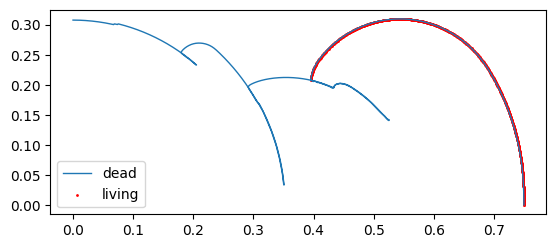

In [3]:
radius = 0.30
d = 1.0
gr = 15
dt = 0.1
Tmax = 30
T0 = 1980
vert_shift = 0.4
num_initial_pts = 200

## post processing
Tmax *= 1.00001
d = d / 1e3
gr = (gr / 1e3) * dt
NT = int(Tmax / dt)

sl_df = pd.read_csv("./data/SeaLevel.csv", header=None, names=["time", "sl"])
sl_arr = sl_df.to_numpy()
sl_arr[:, 1] += vert_shift
band_sl_arr = sim.lowest_discreet(sl_arr, dt, T0, T0 + Tmax)

gr_vec = np.ones(NT) * gr
line, living_status = sim.coral_growth(
    radius, num_initial_pts, d, gr_vec, NT, band_sl_arr[:, 1]
)
living_status = living_status.astype(bool)

plt.plot(line[:, 0], line[:, 1], lw=1, label="dead")
plt.scatter(
    line[:, 0][living_status], line[:, 1][living_status], s=1, c="r", label="living"
)
plt.gca().set_aspect(1)
plt.legend()
plt.show()

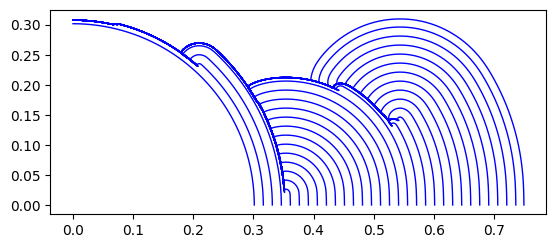

In [11]:
gr_vec = np.ones(NT) * gr
lines, _ = sim.coral_growth_all(
    radius, num_initial_pts, d, gr_vec, NT, band_sl_arr[:, 1]
)
for i, line in enumerate(lines):
    if i % 10 == 0:
        plt.plot(line[:, 0], line[:, 1], lw=1, c="b")

plt.gca().set_aspect(1)
plt.show()

# Analytical solution simulator

Not every inner later is simulated.


In [2]:
DATAFILE01 = "data/Sealevel.dat"
DATAFILE02 = "data/Param.dat"
pi = np.pi

SLin = np.loadtxt(DATAFILE01, comments="#")
gr = np.loadtxt(DATAFILE02, usecols=[1])
gr = gr / 1e3
Nc = SLin.shape[0]  # Number of diedown events

# Arrays for arc segments
# First column:0:BF, 1:MF, 2:TF, 3:TB
# Third column: 0:Ox, 1:Oy, 2:radius, 3:1st endpoint, 4:2nd endpoint
Arcs = np.zeros((4, Nc, 5))

# Diedown point
# Second column: 0:Dx, 1:Dy, 2:Angle of normal vector,
#               3:Location of diedown (0:BF, 1:MF, 2:TF)
DD = np.zeros((Nc, 4))

# Surface trace
Sfc = np.zeros((100, 5))
# Initial shape and diedown
R = gr * SLin[0, 0]  # radius
Arcs[:, 0, 2] = R
Arcs[2, 0, 4] = pi / 2
Arcs[3, 0, 3] = pi / 2
Arcs[3, 0, 4] = pi / 2

DD[0, 0] = np.sqrt(R * R - SLin[0, 1] * SLin[0, 1])
DD[0, 1] = SLin[0, 1]
DD[0, 2] = np.arctan2(DD[0, 1], DD[0, 0])
DD[0, 3] = 0

Sfc[0, :5] = [0, 0, R, DD[0, 2], pi / 2]
Isf = 0

In [3]:
from microatoll_sim.analytical_simulator import growth

In [4]:
%timeit growth(Nc, gr, Isf, SLin, Arcs, DD, Sfc)

5.79 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# 186 µs ± 335 ns - before njit
# 5.79 µs ± 3.4 µs per loop - after njit (mean ± std. dev. of 7 runs, 1 loop each)